In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/518.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1307.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1048.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1399.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1661.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1577.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/665.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1212.bmp
/kaggle/input/leukemia-classification

In [33]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'

dataset = datasets.ImageFolder(root=data_dir)

In [35]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'

dataset1 = datasets.ImageFolder(root=data_dir)

In [36]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'

dataset2 = datasets.ImageFolder(root=data_dir)

In [37]:
from torch.utils.data import ConcatDataset
datasets_all = ConcatDataset([dataset, dataset1, dataset2])

In [38]:
len(dataset)

3527

In [39]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [40]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [41]:
image_tensor, label = dataset[2]

In [42]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(45)),
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset.classes
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [43]:
len(train_data), len(val_data)

(2822, 705)

In [44]:
dataset = TransformDataset(dataset, transform=train_transform)

In [45]:
batch_size = 32

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

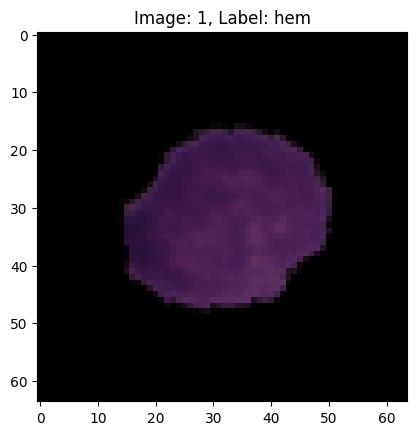

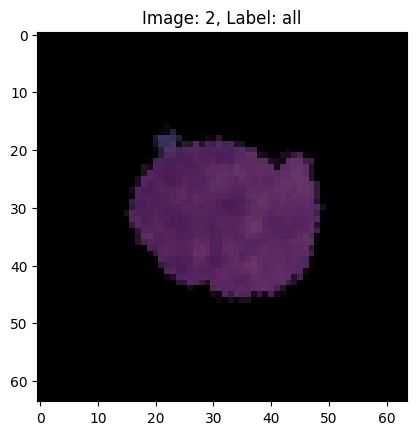

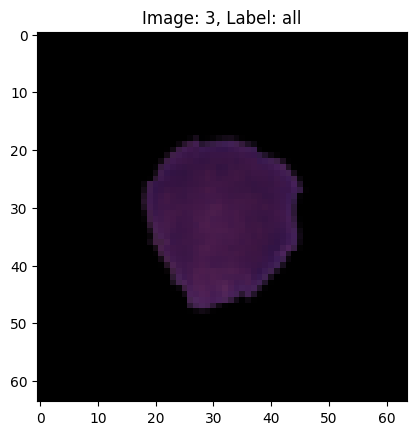

In [46]:
import matplotlib.pyplot as plt
import random

for i in range(3):  # Show 3 images
    rand = random.randint(0, 10661) 
    img, label = dataset[rand]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

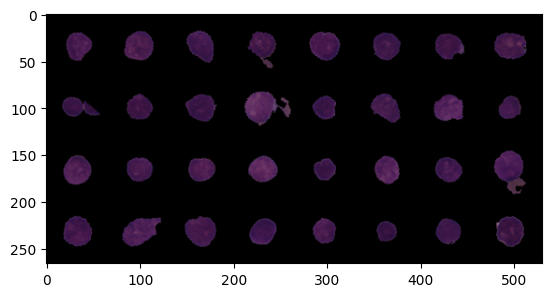

In [47]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)
  
batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)

In [48]:
batch.shape

torch.Size([32, 3, 64, 64])

In [58]:
import numpy as np
from torch import nn
import torch.nn.functional as F

class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(32*2*2, num_classes)
        

    def forward(self, x):
        out = self.conv1(x) 
        out = F.relu(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out) 
    
        out = self.conv3(out) 
        out = F.relu(out)
        
        out = self.pool2(out)
        
        out = self.conv4(out) 
        out = F.relu(out)
        
        out = self.pool3(out) 
        
        out = self.conv5(out) 
        out = F.relu(out)
        
        out = self.pool4(out)
        
        out = self.flat(out) 
        
        out = self.linear(out)
        
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()
    
model = FractureClassifier(len(train_data.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

In [51]:
!pip install -q torchsummary

In [59]:
from torchsummary import summary

summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 62, 62]             224
            Conv2d-2           [-1, 16, 60, 60]           1,168
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 12, 12]           9,248
         MaxPool2d-7             [-1, 32, 6, 6]               0
            Conv2d-8             [-1, 32, 4, 4]           9,248
         MaxPool2d-9             [-1, 32, 2, 2]               0
          Flatten-10                  [-1, 128]               0
           Linear-11                    [-1, 2]             258
Total params: 24,786
Trainable params: 24,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/ba

In [60]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=FractureClassifier, opt=Adam(lr=0.001000), epochs=20, device=cpu

Epoch    1   44sec	loss:      0.604	val_loss:      0.475	accuracy_score:       0.68	val_accuracy_score:      0.803	
Epoch    2   19sec	loss:      0.466	val_loss:      0.456	accuracy_score:      0.797	val_accuracy_score:      0.807	
Epoch    3   19sec	loss:      0.447	val_loss:      0.446	accuracy_score:      0.808	val_accuracy_score:      0.818	
Epoch    4   18sec	loss:      0.425	val_loss:      0.449	accuracy_score:      0.823	val_accuracy_score:      0.817	
Epoch    5   19sec	loss:      0.422	val_loss:       0.44	accuracy_score:      0.826	val_accuracy_score:      0.811	
Epoch    6   20sec	loss:      0.426	val_loss:      0.447	accuracy_score:      0.822	val_accuracy_score:      0.806	
Epoch    7   21sec	loss:      0.425	val_loss:       0.44	accuracy_score:      0.821	val_accuracy_score:      0.823	
Epoch    8   20sec	loss:      0.424	val_loss:      0.441	accuracy_score:      0.827	val_accuracy_sco

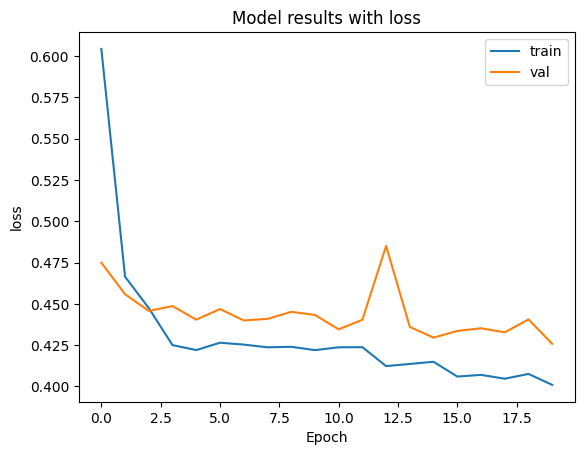

In [67]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

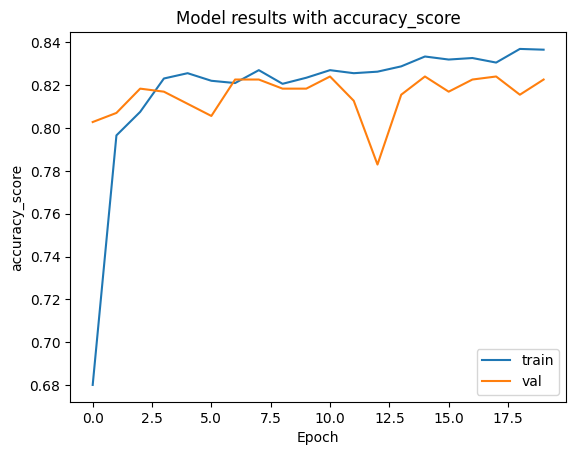

In [68]:
plot_metric(history, 'accuracy_score')

[]

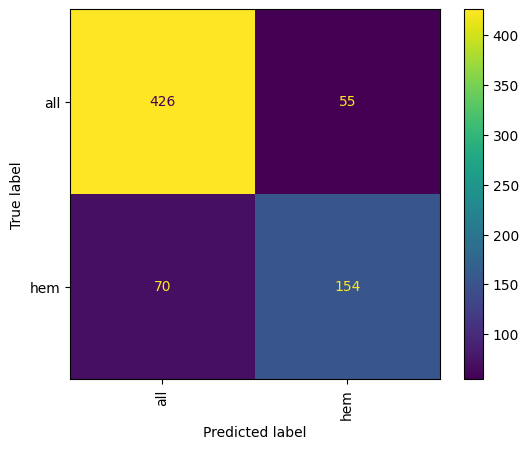

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=val_data.classes)
plt.xticks(rotation=90)
plt.plot()

In [71]:
y_pred[0].sum()

1.0

In [73]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=val_data.classes))

              precision    recall  f1-score   support

         all       0.86      0.89      0.87       481
         hem       0.74      0.69      0.71       224

    accuracy                           0.82       705
   macro avg       0.80      0.79      0.79       705
weighted avg       0.82      0.82      0.82       705

